#Torus bend noisy  line elements

Using Bayesian Gaussian process latent variable model to discover a latent space representation of the line elements of a bend torus with added noise.

Made by Ivan De Boi (ivan.deboi at uantwerpen.be, http://www.InViLab.be).

In [ ]:
shape_name_string = 'Torus bend noisy'

# Imports

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
%matplotlib inline
from mpl_toolkits import mplot3d

import warnings
warnings.filterwarnings('ignore')

from matplotlib import cm

!pip install GPy
import GPy
from GPy.util import pca
from GPy import kern
GPy.plotting.change_plotting_library('matplotlib')

from sklearn.preprocessing import StandardScaler

import plotly.graph_objects as go

from numpy import genfromtxt

from google.colab import drive
from google.colab import files

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#use this to adjust the resolution of the pictures etc.
#print(plt.rcParams)  # it will tell you all default setting in Matplotlib
print(plt.rcParams.get('figure.figsize'))
plt.rcParams['figure.figsize'] = [8,6]
print(plt.rcParams.get('figure.figsize'))
print(plt.rcParams.get('figure.dpi'))
plt.rcParams['figure.dpi'] = 72.0*5
print(plt.rcParams.get('figure.dpi'))

[6.0, 4.0]
[8.0, 6.0]
72.0
360.0


# Data

In [ ]:
drive.mount('/content/gdrive')
root_path = 'gdrive/My Drive/PhD 3D Sensing/05 GPLVM on set of lines/Line Elements Surface/Line Elements/'  #change dir to your project folder

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data = genfromtxt(root_path + shape_name_string + ' line elements.csv', delimiter=',')
shape_name_string
Y = data[:,:]
print(Y[0:3,:])
print(Y.shape)

[[ 0.94905162 -0.04280834  0.31219929  0.03471494 -0.07681042 -0.11606175
   1.10803139]
 [ 0.95785433  0.17214601  0.22995858 -0.02419555  0.04018053  0.0707036
   1.12792337]
 [ 0.83293533  0.13361511  0.53699702  0.01892213 -0.29416481  0.04384372
   1.10549891]]
(8192, 7)


# PCA

In [ ]:
# Normalize
scaler = StandardScaler()
scaler.fit(Y)

Yn = scaler.transform(Y)
print(Yn[0:3, :])

# Sanity checks
print("mean y:",Y.mean())
print("std y:", Y.std())
print("mean yn:", Yn.mean())
print("std yn:", Yn.std())

[[ 1.77296763 -0.07393308  0.47723106  0.10280438 -0.20843871 -0.56773217
   1.41342795]
 [ 1.78943228  0.33926729  0.35373567 -0.06110254  0.11034653  0.36243283
   1.45147366]
 [ 1.55578294  0.26520048  0.8147948   0.05886397 -0.80070134  0.22866009
   1.40858429]]
mean y: 0.05080022751441694
std y: 0.49217720277296645
mean yn: 0.0
std yn: 0.999999999999999


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

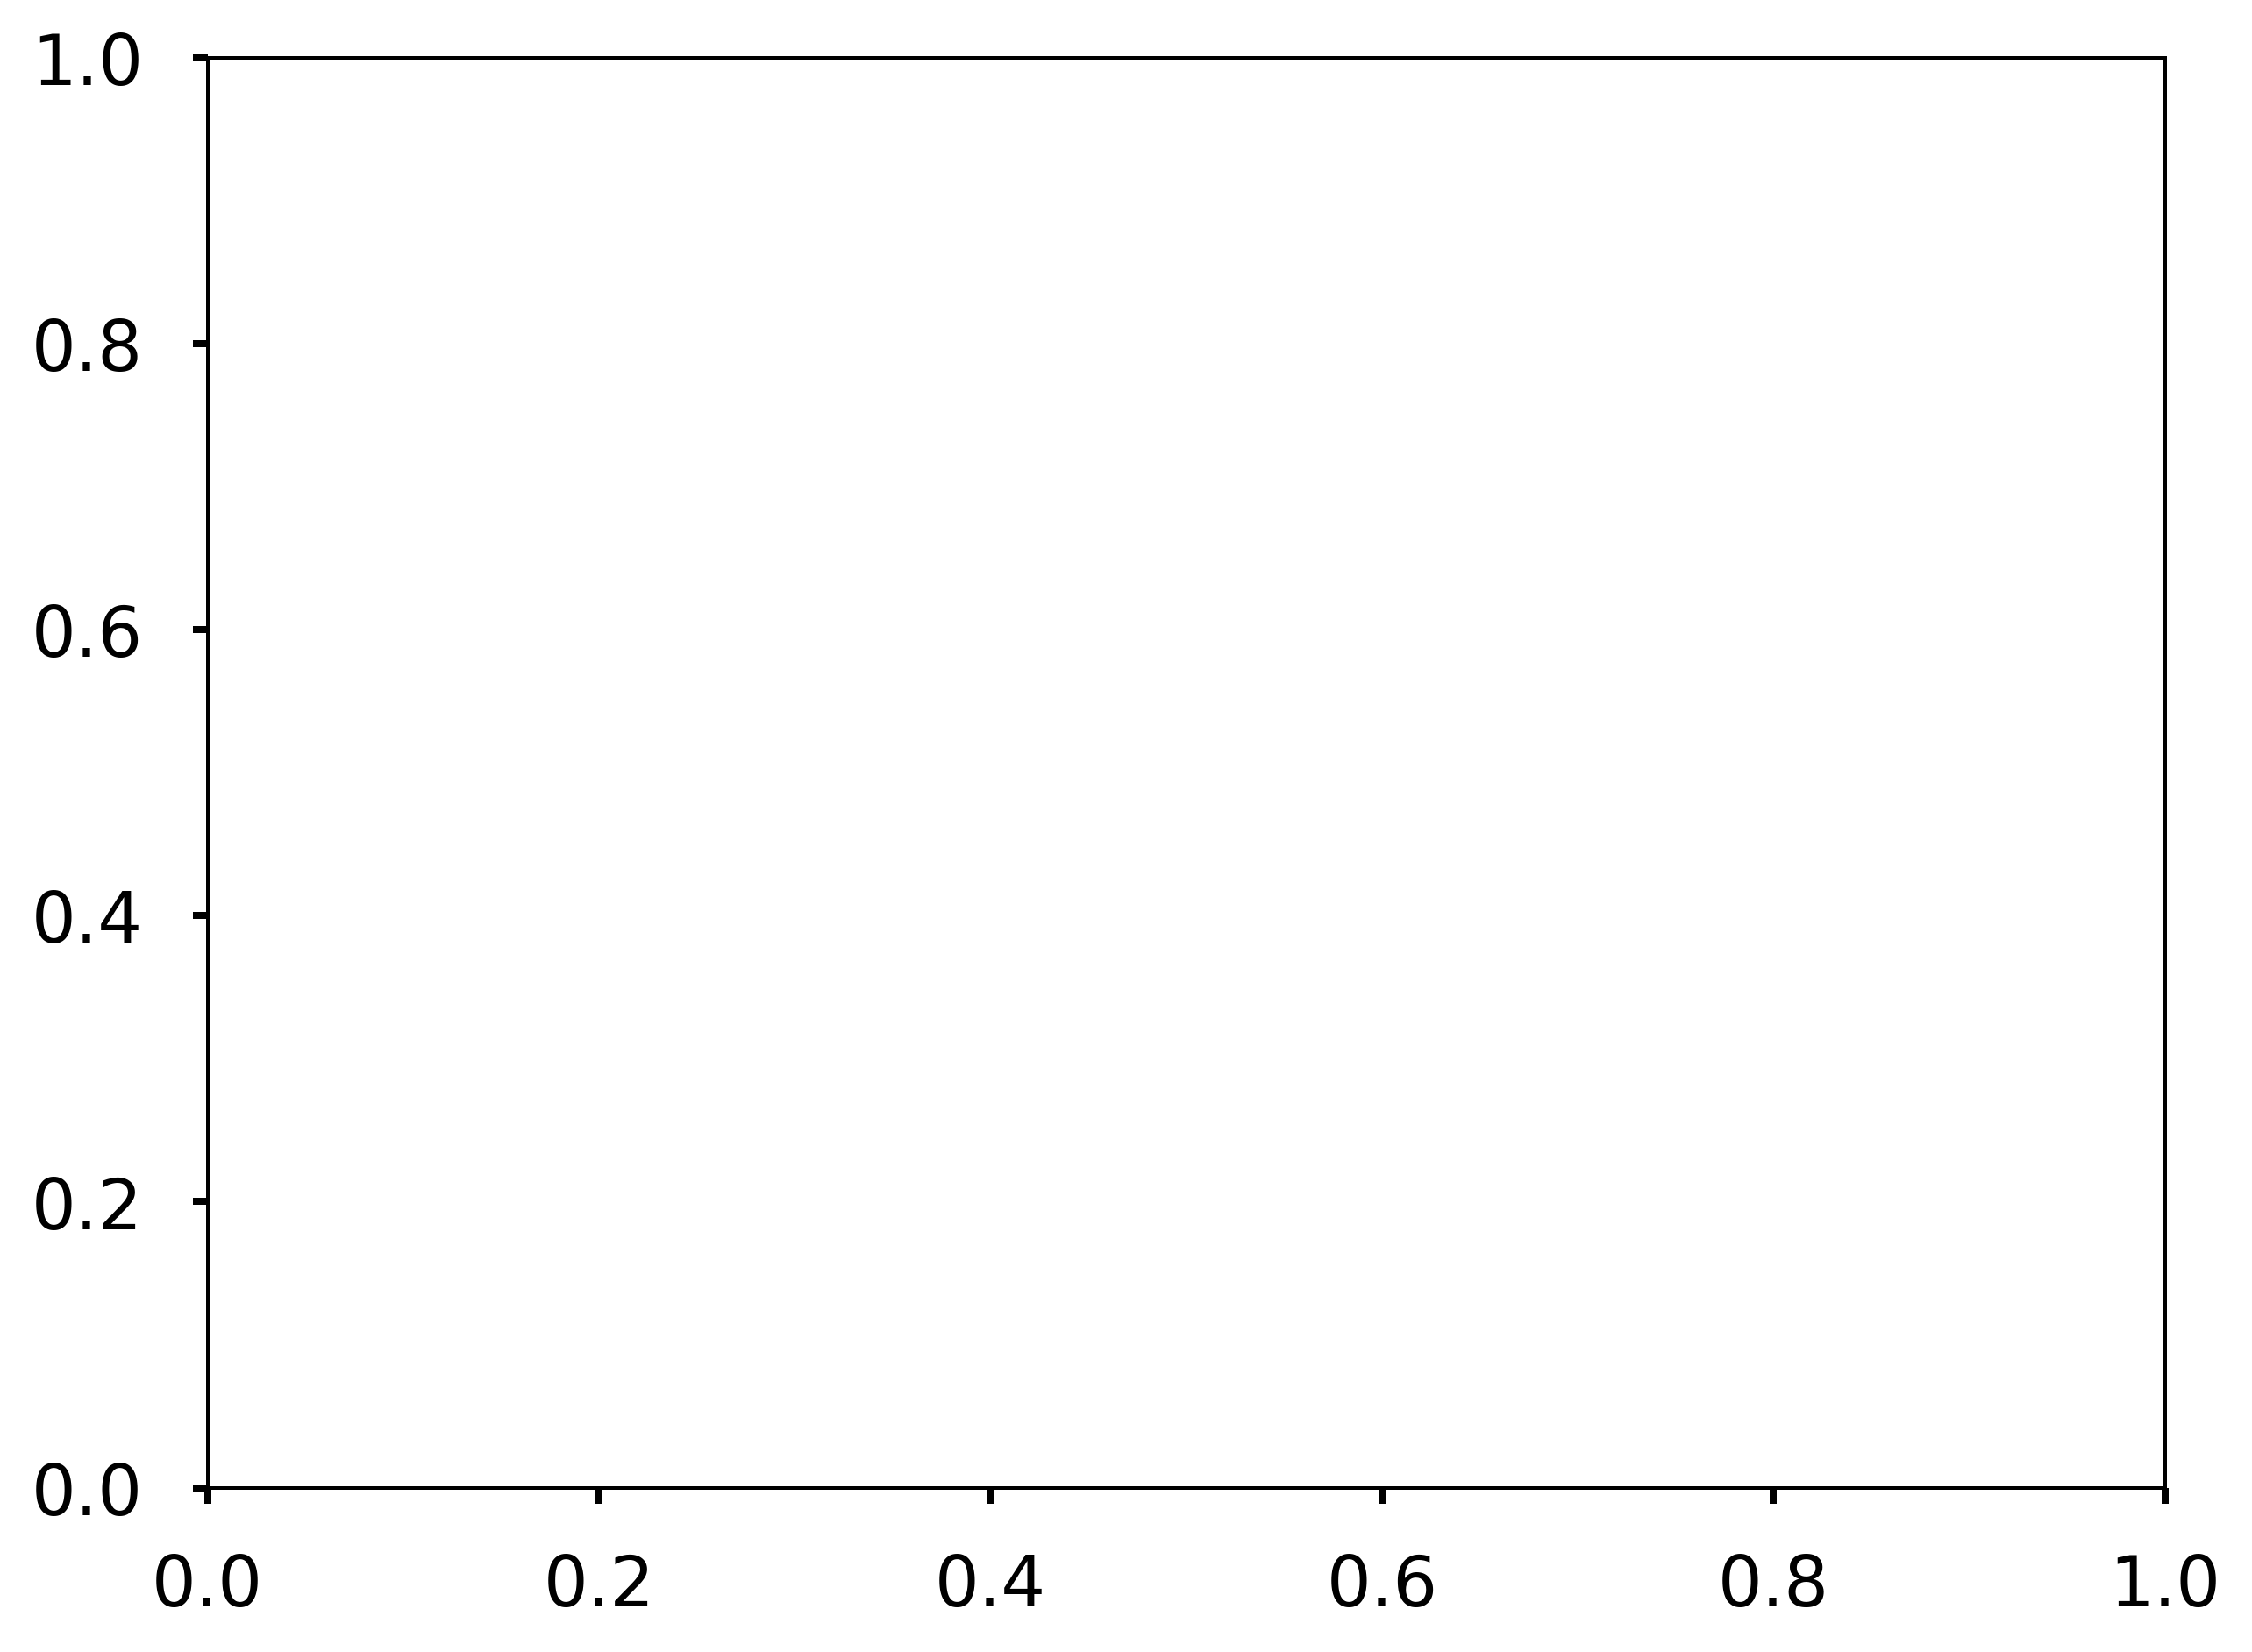

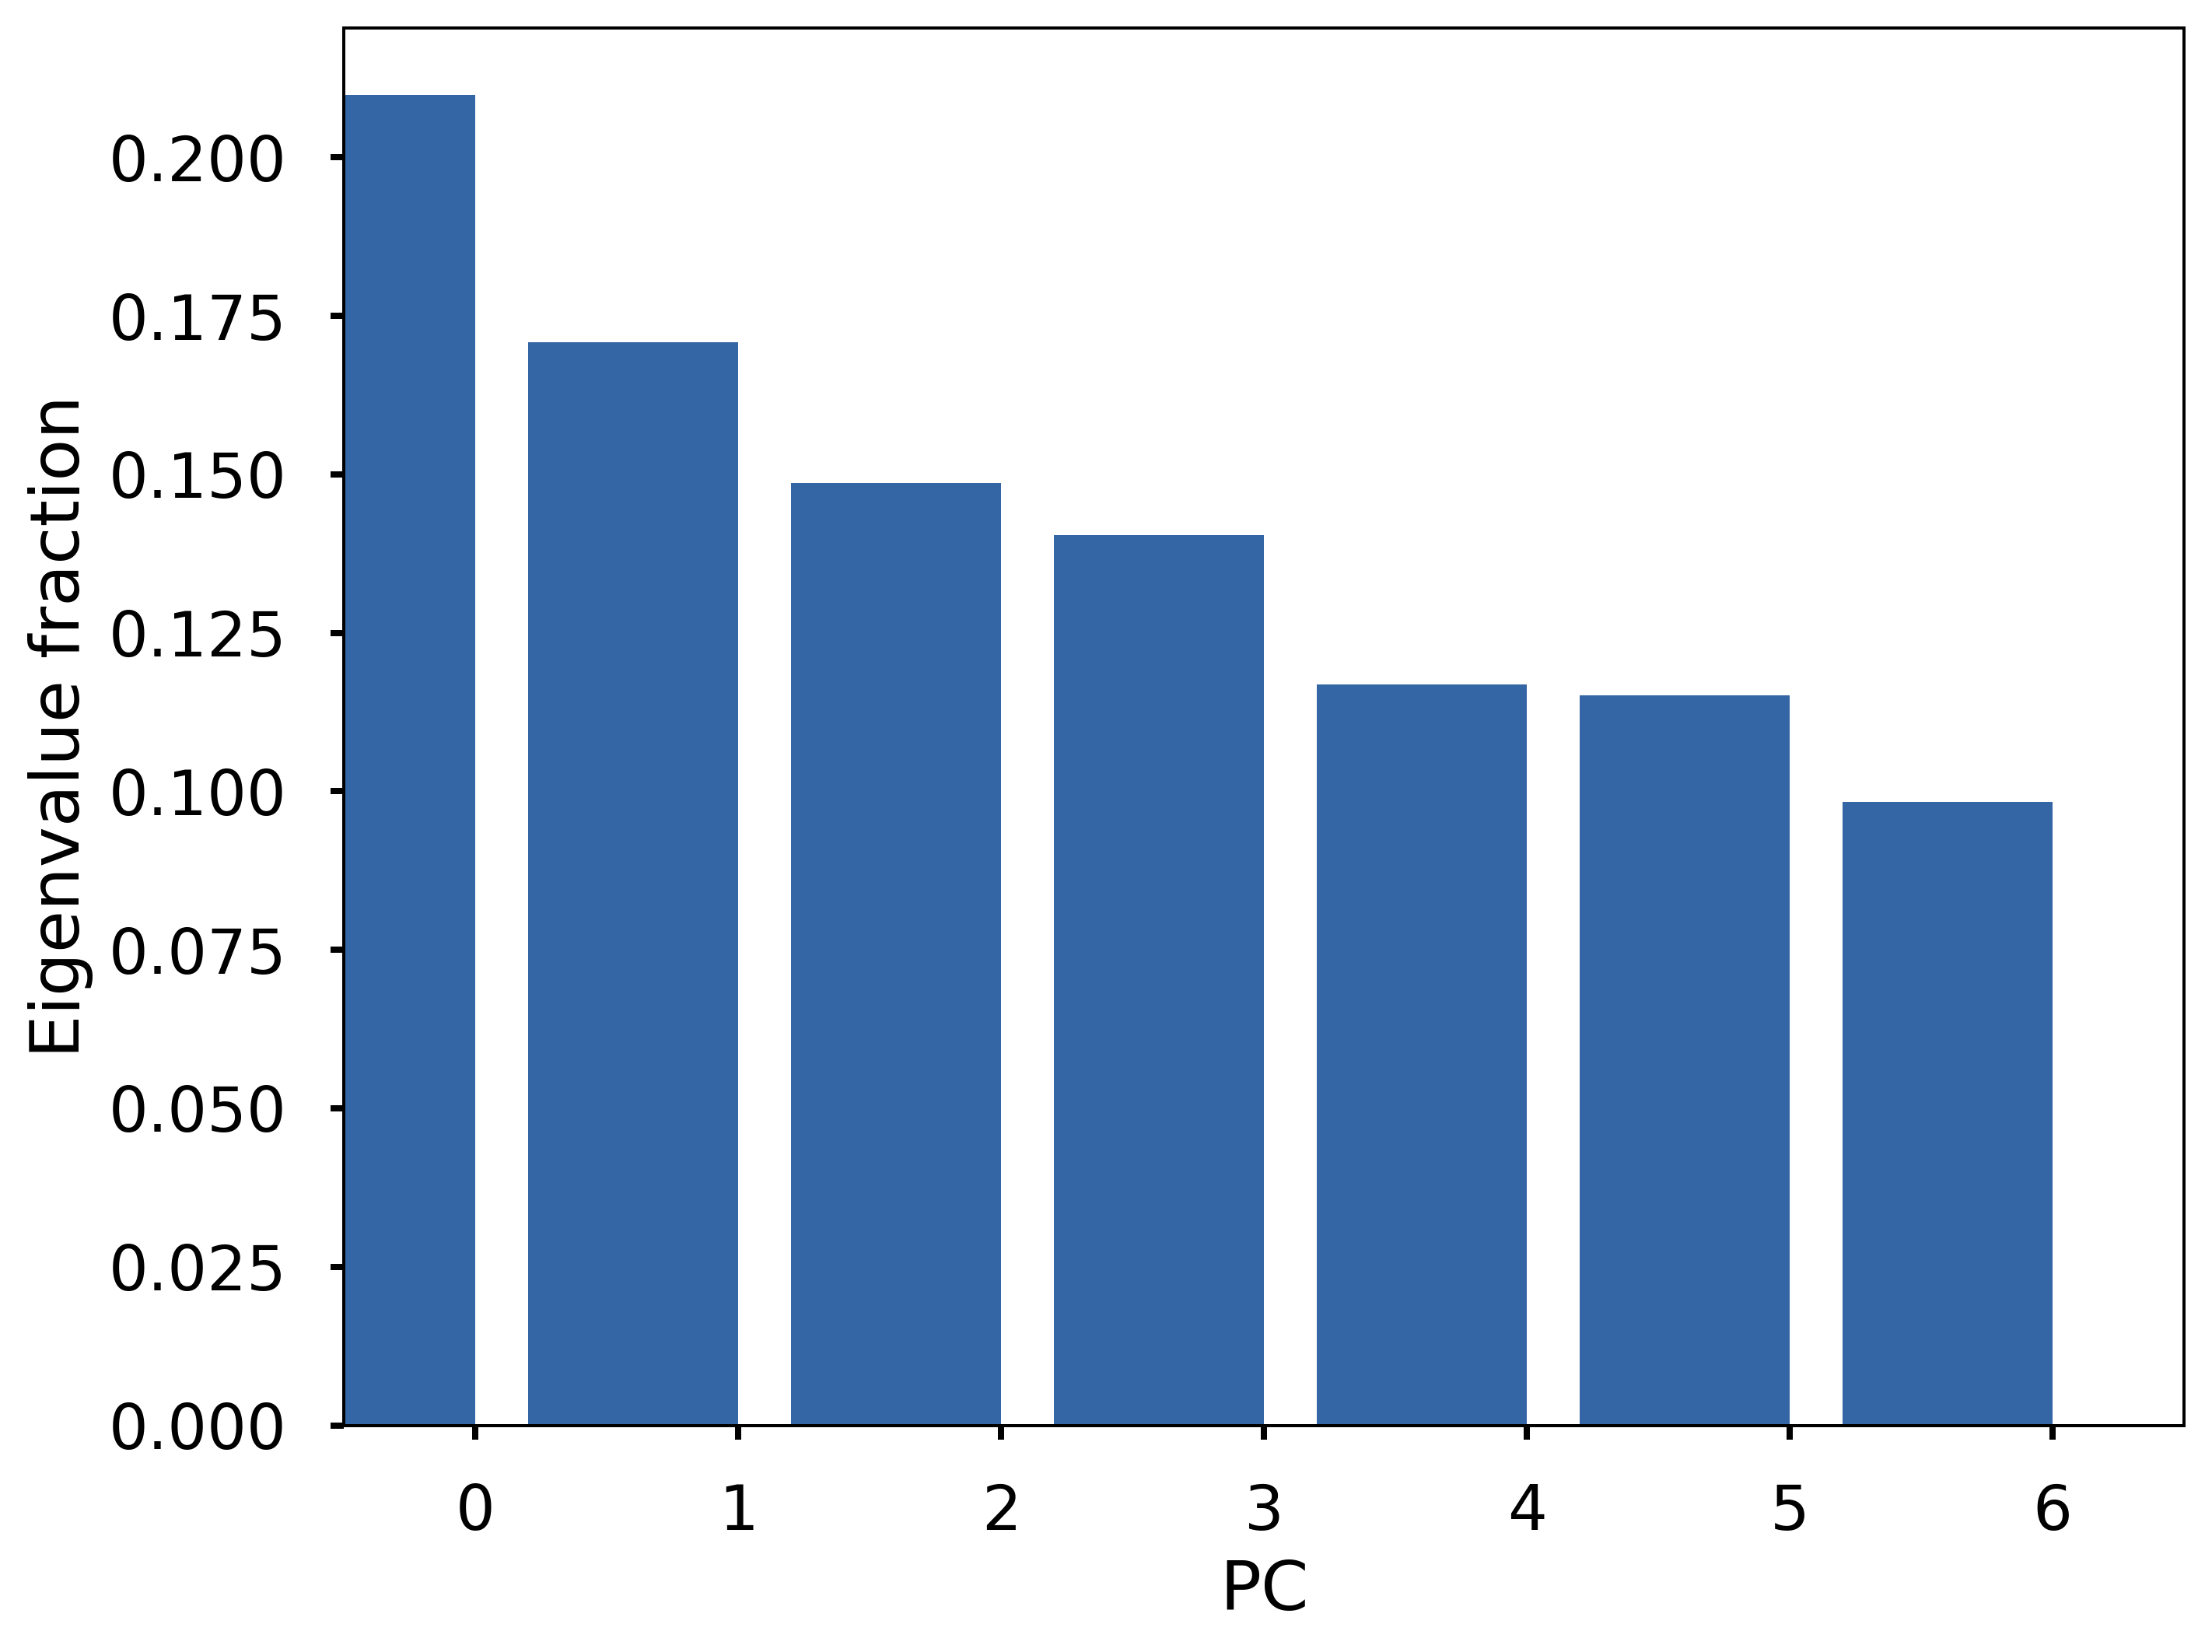

In [ ]:
p = pca.PCA(Yn)
# plot first xxx eigenvalue fractions

fig, ax = plt.subplots()
p.plot_fracs(Yn.shape[1]) 

filename = shape_name_string + ' PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

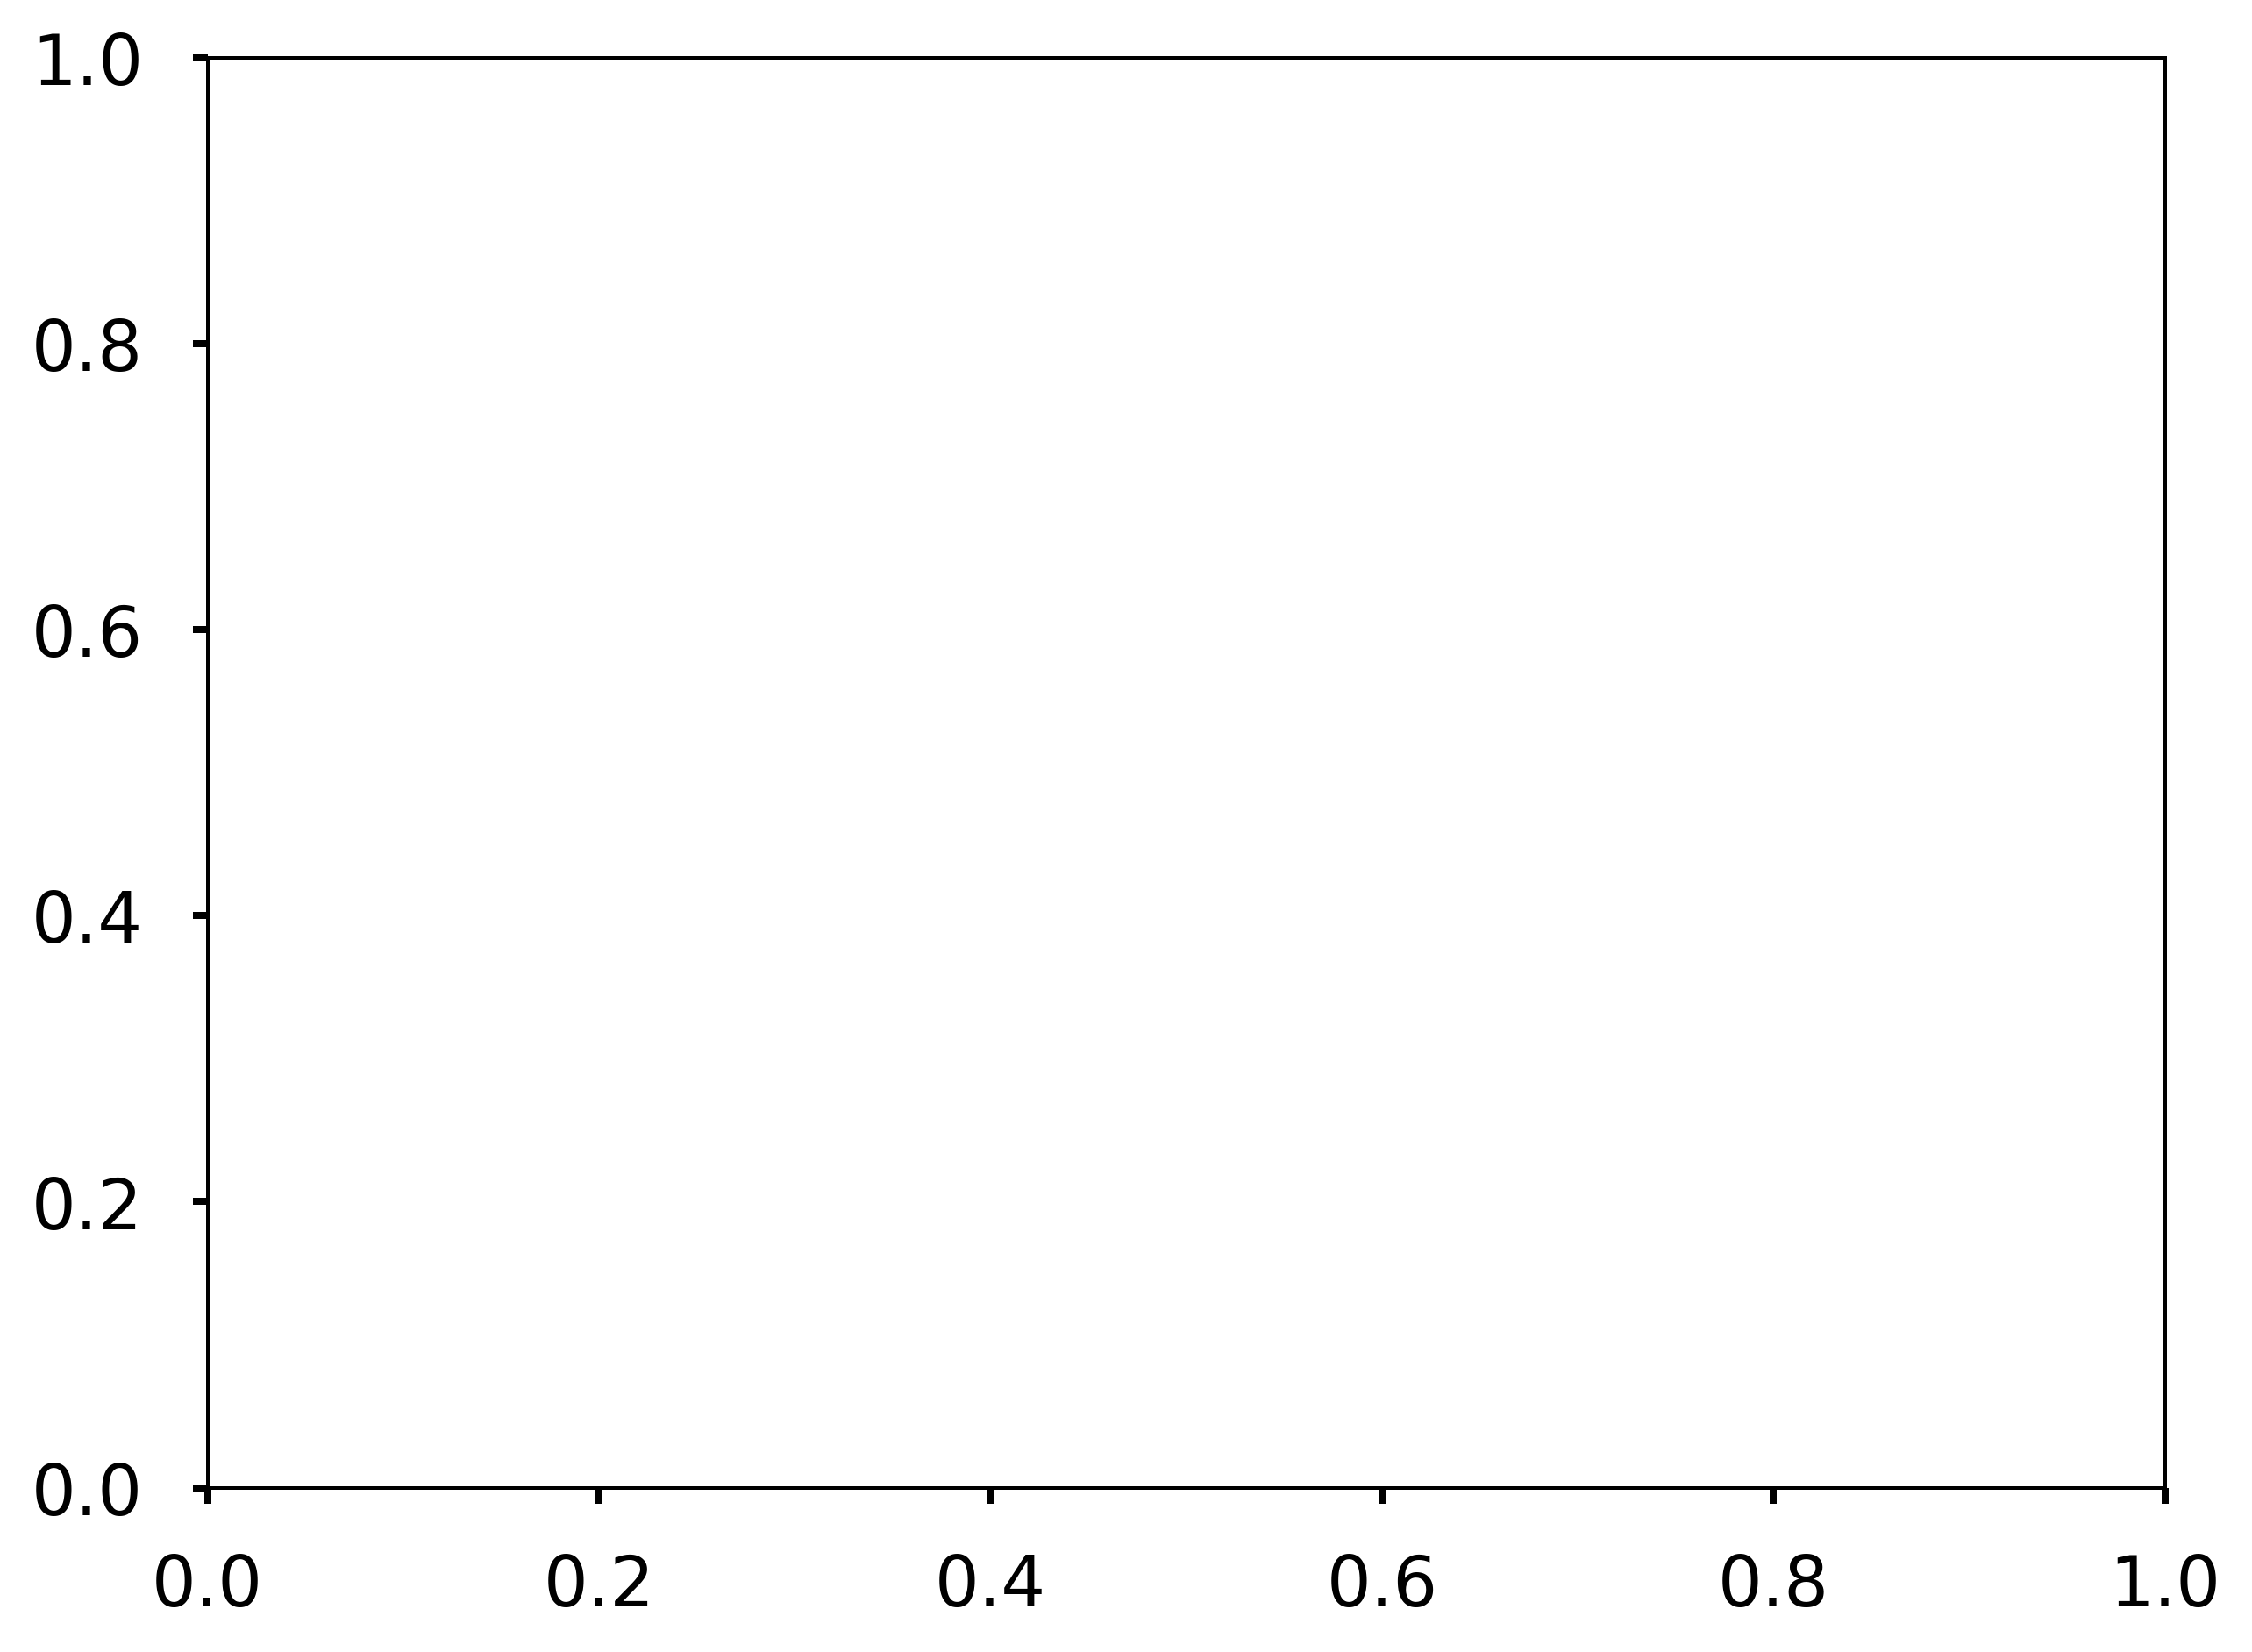

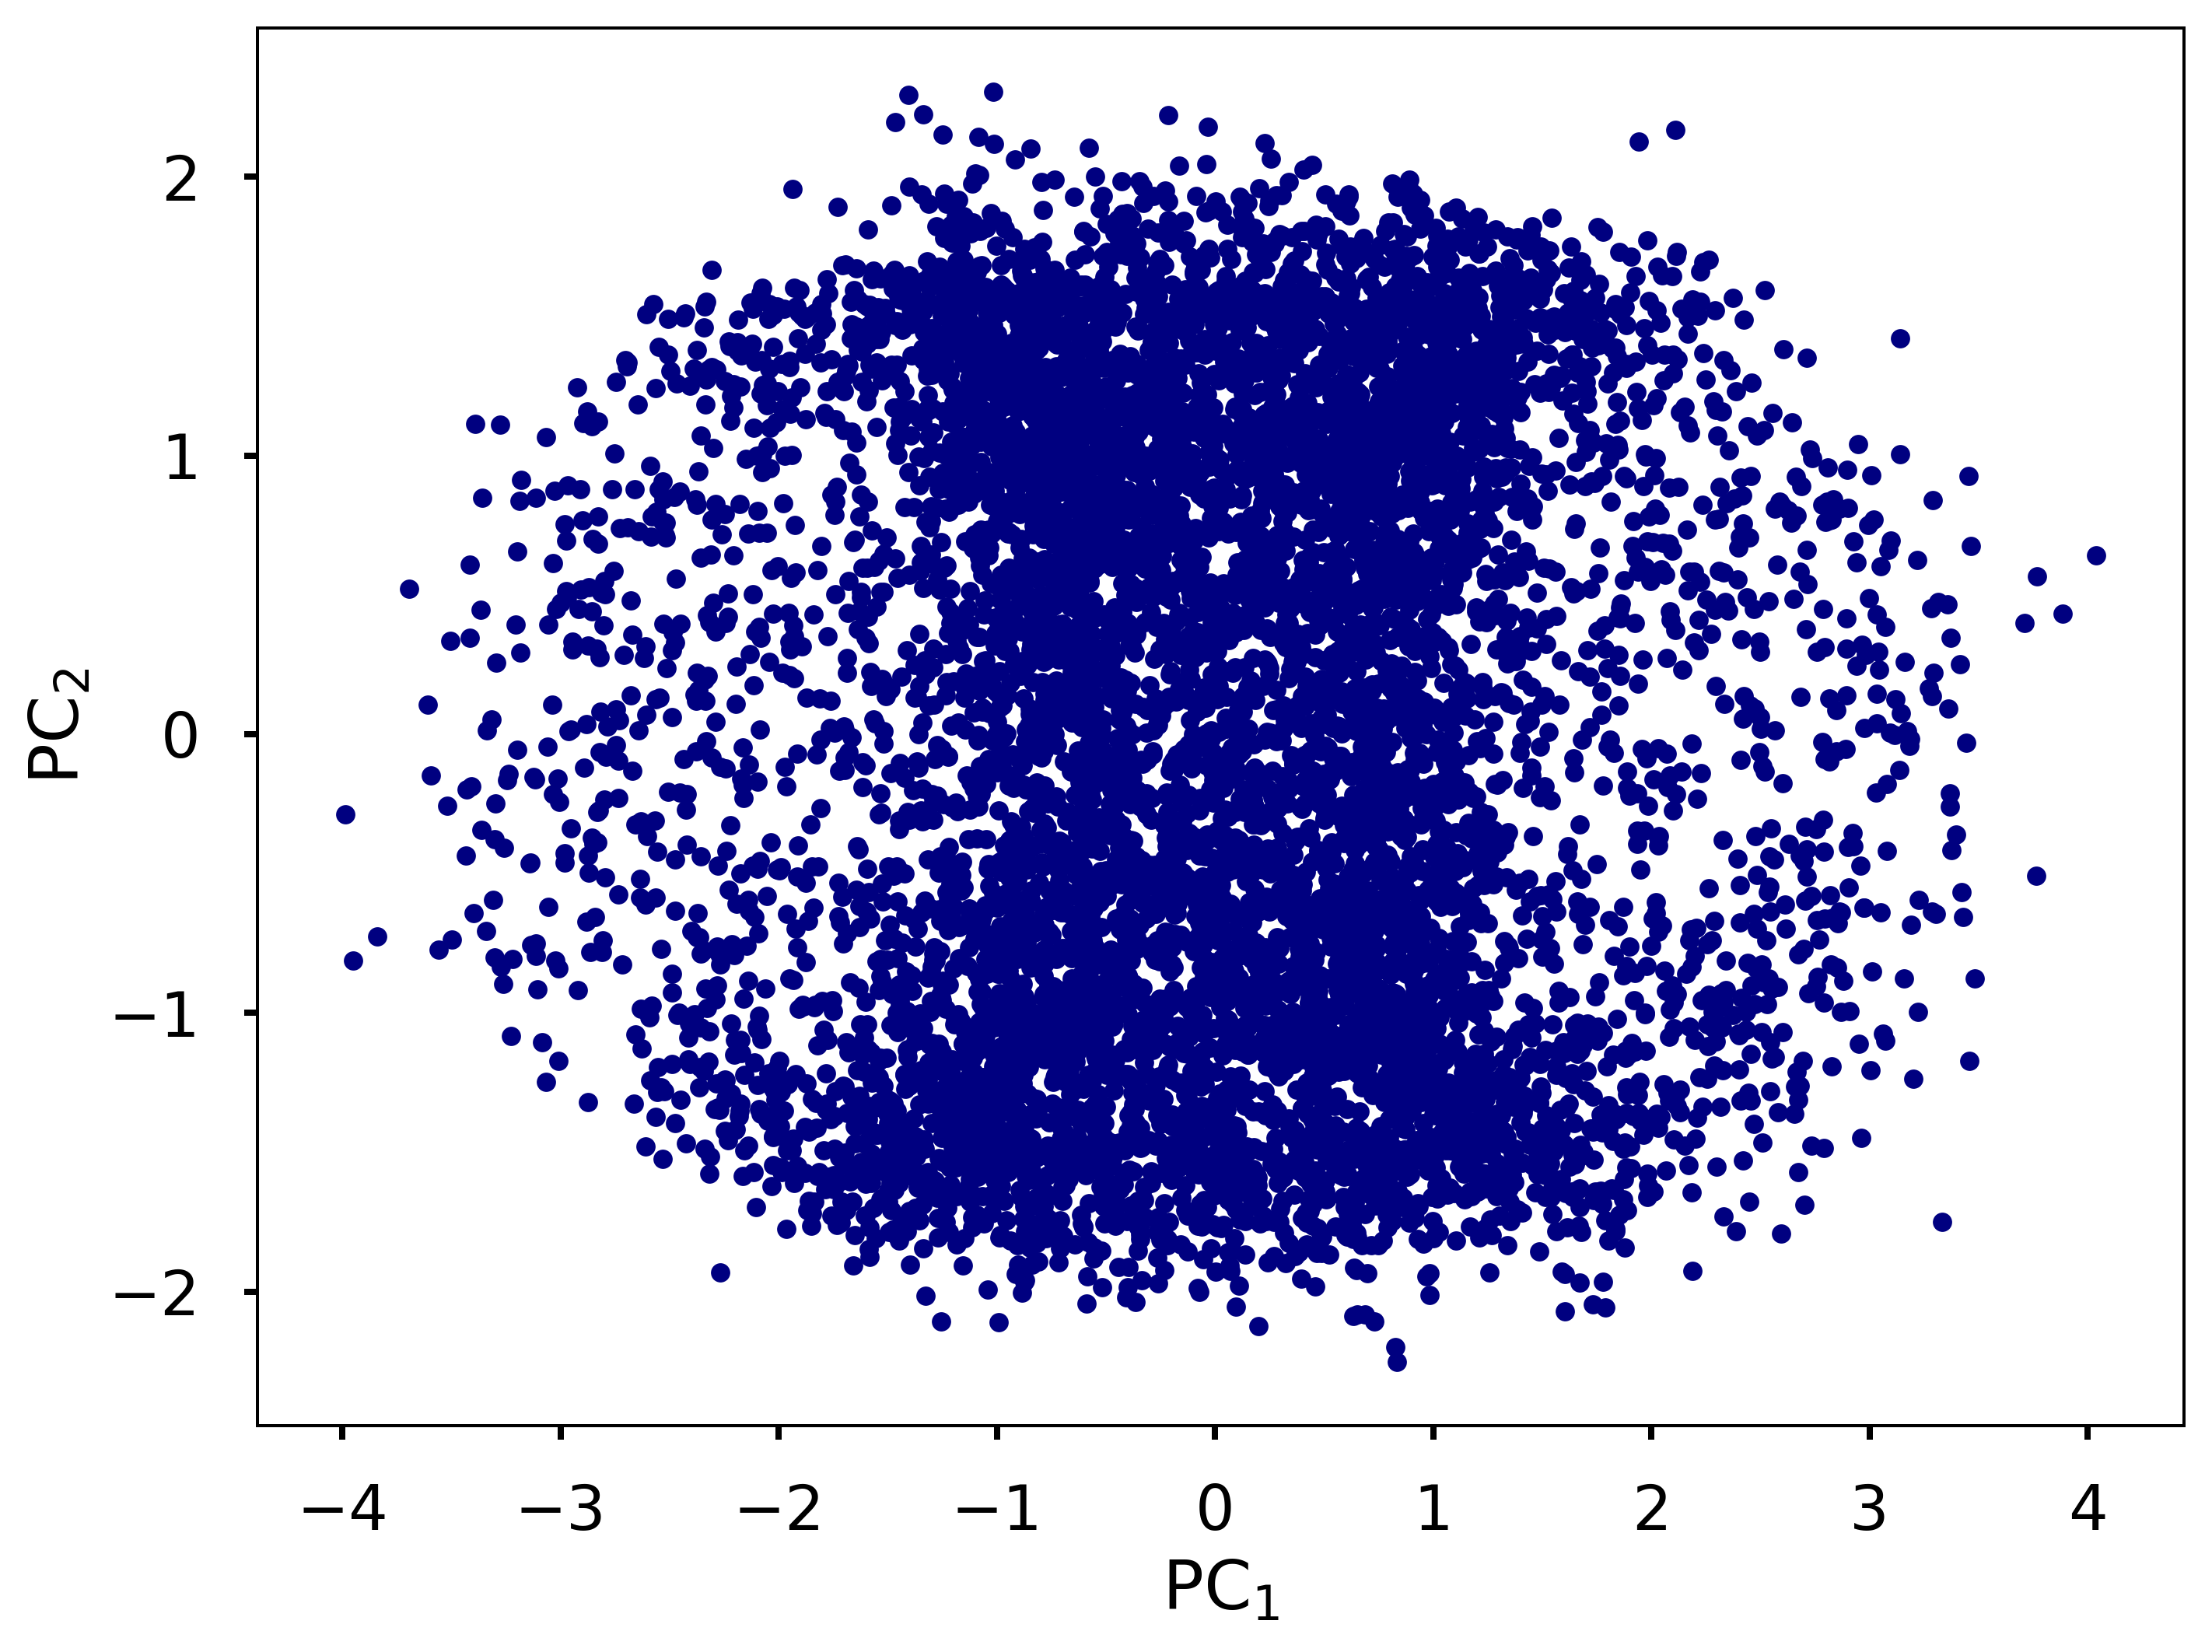

In [ ]:
# plot the latent space by PCA

fig, ax = plt.subplots()
p.plot_2d(Yn)

filename = shape_name_string + ' 2D PCA.png'
plt.savefig(filename)
files.download('/content/' + filename)

# BGPLVM

In [ ]:
max_nr_of_data_points = 5000 #use this line to subsample
max_nr_of_data_points = Y.shape[0]
Y = Y[np.random.choice(Y.shape[0], max_nr_of_data_points, replace=False), :] #permutation on the datapoints
print(Y.shape)

points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3] #calculate the points from the line elements
  points[i,:] = p
print(points.shape)


plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = points[:, 2])
ax.set_title('Points in training')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' points in training.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
max_nr_of_iters = 20000

init='PCA'
#init='random'

likelihood_variance = 1e-6
likelihood_variance_fix = False #use this to fix the noiselevel

optimizer = 'scg'
optimizer = 'lbfgs'
#optimizer = 'tnc'

num_restarts = 5

input_dim = 7 #Y.shape[1]
num_inducing = 50 

In [ ]:
k_GPLVM = GPy.kern.RBF(input_dim, ARD = True)

m_GPLVM = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing)

if likelihood_variance_fix:
  m_GPLVM.likelihood.variance = likelihood_variance
  m_GPLVM.likelihood.variance.fix()

m_GPLVM.optimize_restarts(messages=1, num_restarts=num_restarts, max_iters=max_nr_of_iters, optimizer = optimizer) 
print(m_GPLVM) 

Optimization restart 1/5, f = 10514.75247587054


Optimization restart 2/5, f = 41019.354679797645


Optimization restart 3/5, f = 41019.378498540595


Optimization restart 4/5, f = 41019.38326224641


Optimization restart 5/5, f = 41019.426542854555

Name : bayesian gplvm
Objective : 10514.75247587054
Number of Parameters : 115047
Number of Optimization Parameters : 115047
Updates : True
Parameters:
  bayesian_gplvm.          |                 value  |  constraints  |  priors
  latent_space.mean        |             (8192, 7)  |               |        
  latent_space.variance    |             (8192, 7)  |      +ve      |        
  inducing_inputs          |               (50, 7)  |               |        
  rbf.variance             |  0.021473633163468165  |      +ve      |        
  rbf.lengthscale          |                  (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.003120824611785581  |      +ve      |        


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

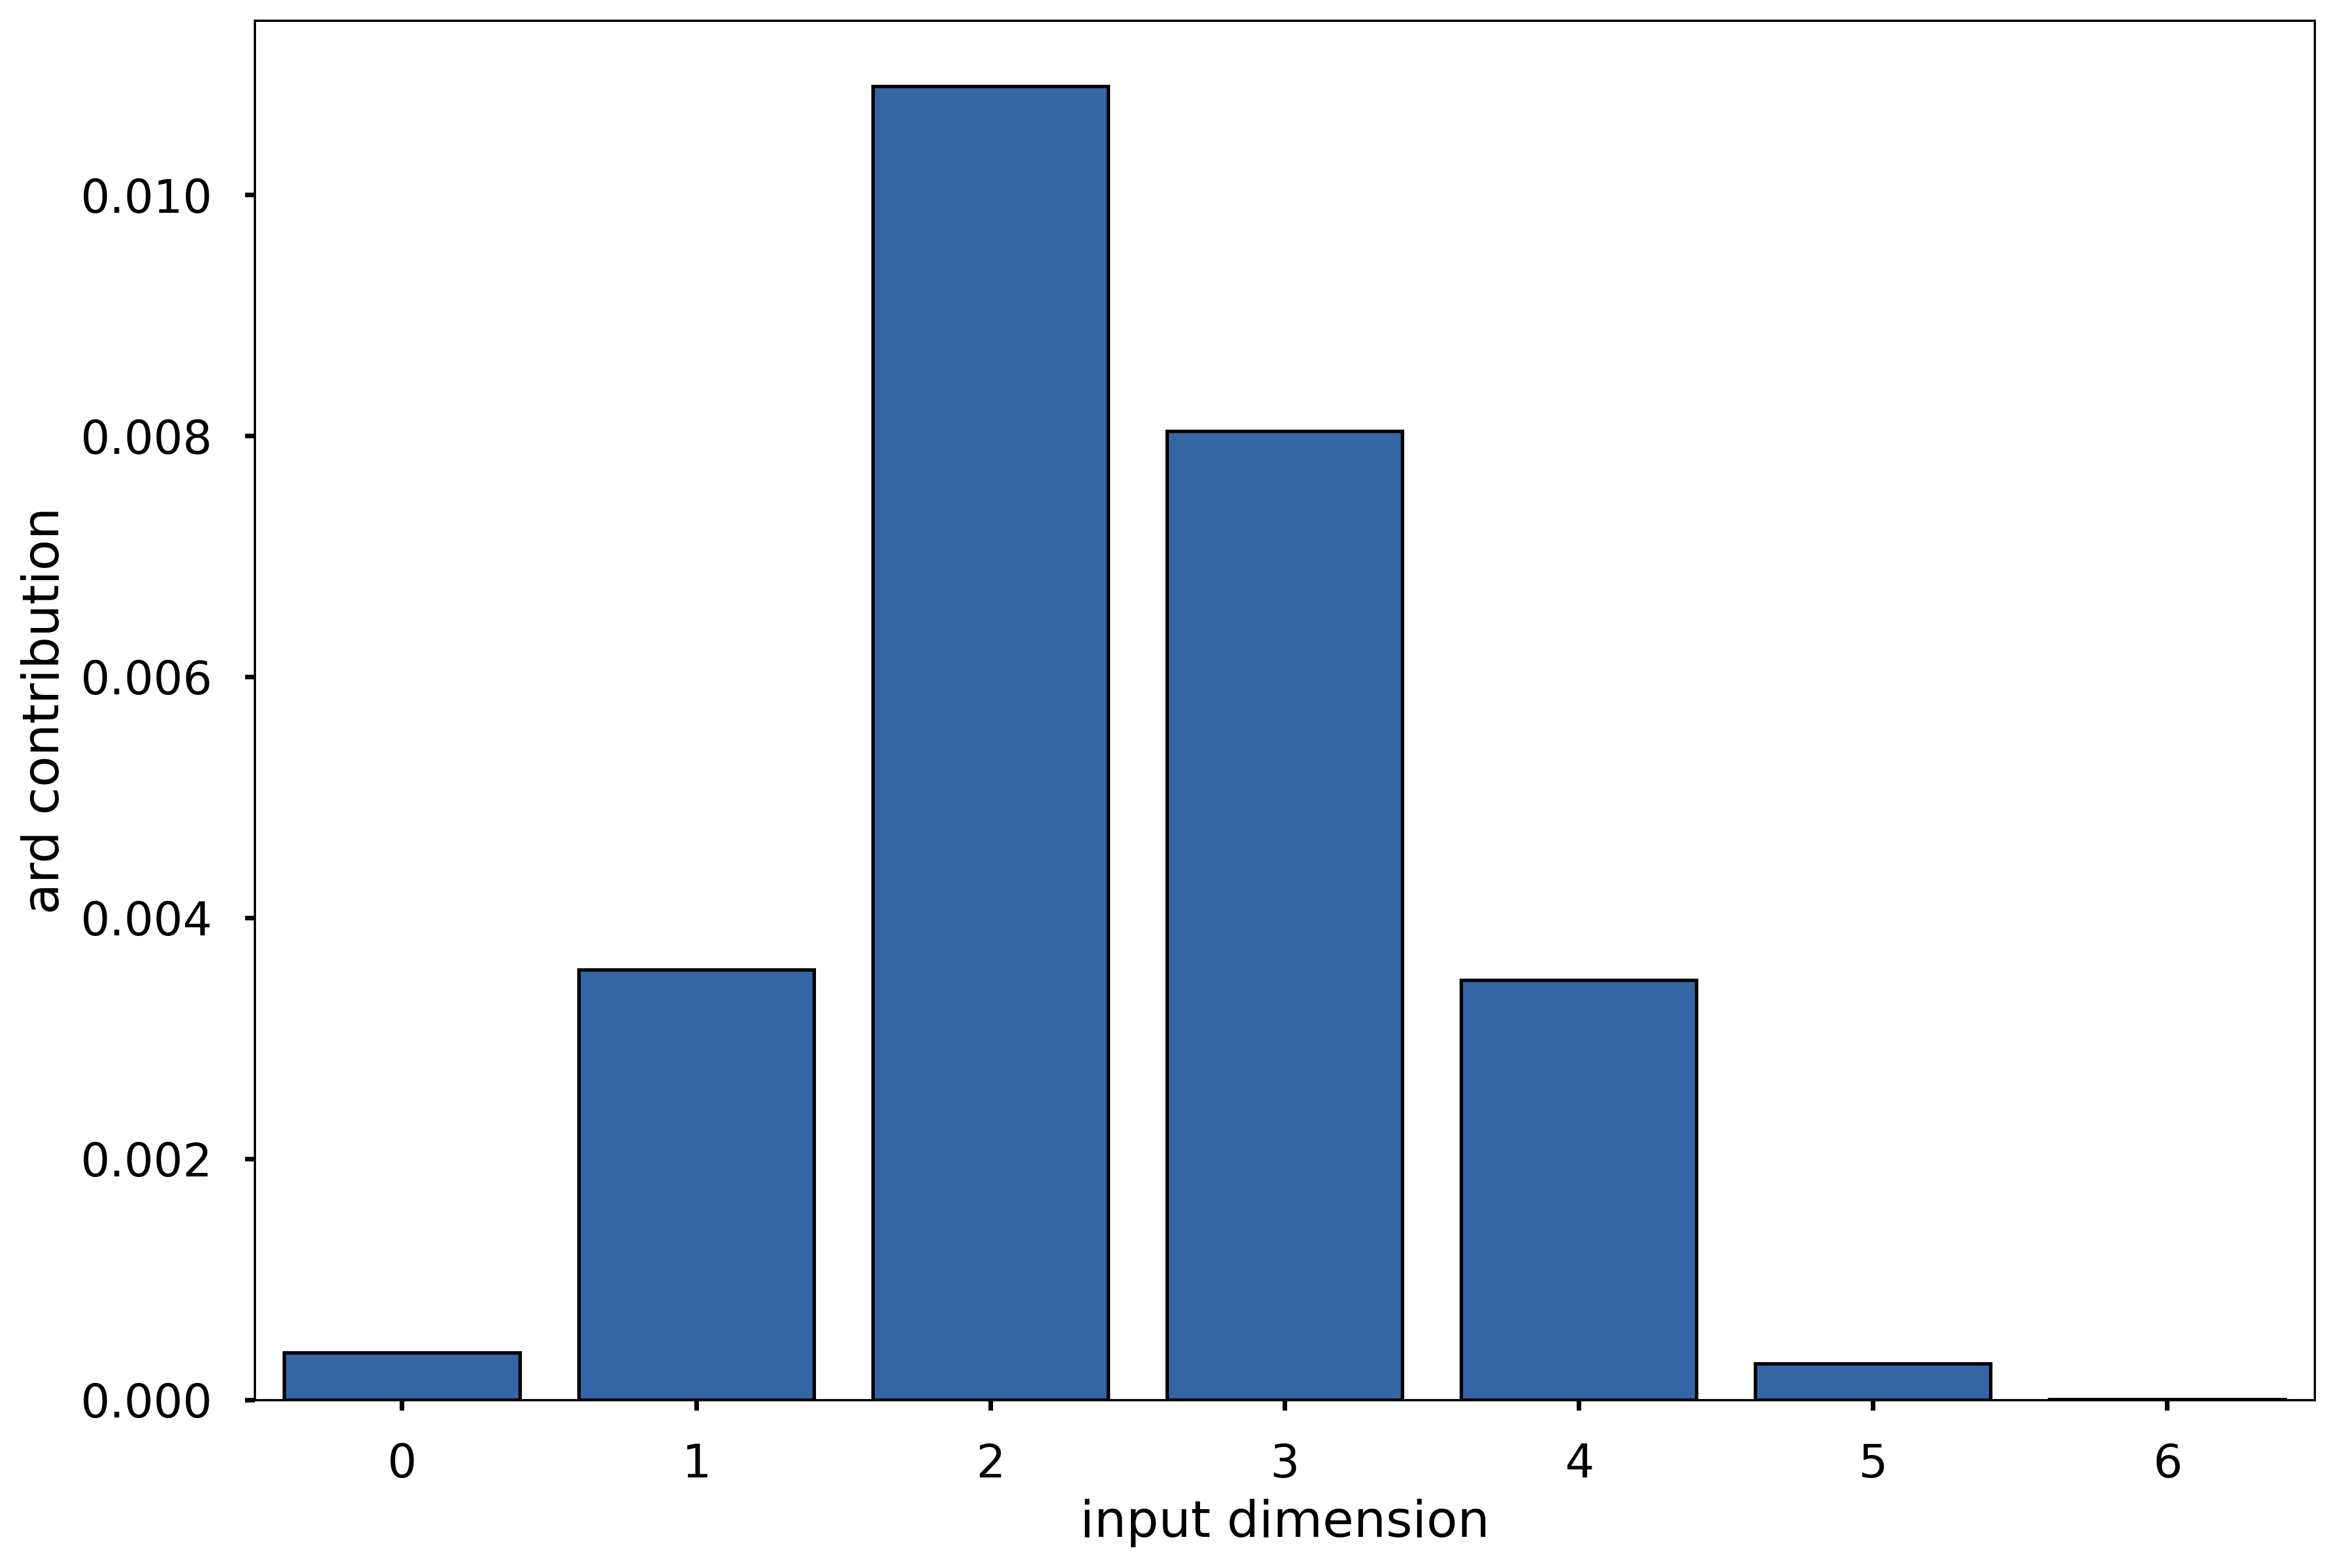

In [ ]:
fig, ax = plt.subplots()
m_GPLVM.kern.plot_ARD(ax=ax)

filename = shape_name_string + ' ARD.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [ ]:
m_GPLVM.kern.lengthscale #which is the inverse of ARD contribution

index,bayesian_gplvm.rbf.lengthscale,constraints,priors
[0],7.43932550,+ve,
[1],2.45350469,+ve,
[2],1.40355905,+ve,
[3],1.63453700,+ve,
[4],2.48301717,+ve,
[5],8.49454191,+ve,
[6],99.18829827,+ve,


In [ ]:
lengthscales = m_GPLVM.kern.lengthscale.argsort()
input_dimension_1 =lengthscales[0]
input_dimension_2 =lengthscales[1]
input_dimension_3 =lengthscales[2]

print(input_dimension_1)
print(input_dimension_2)
print(input_dimension_3)

2
3
1


In [ ]:
latent = m_GPLVM.X.mean 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

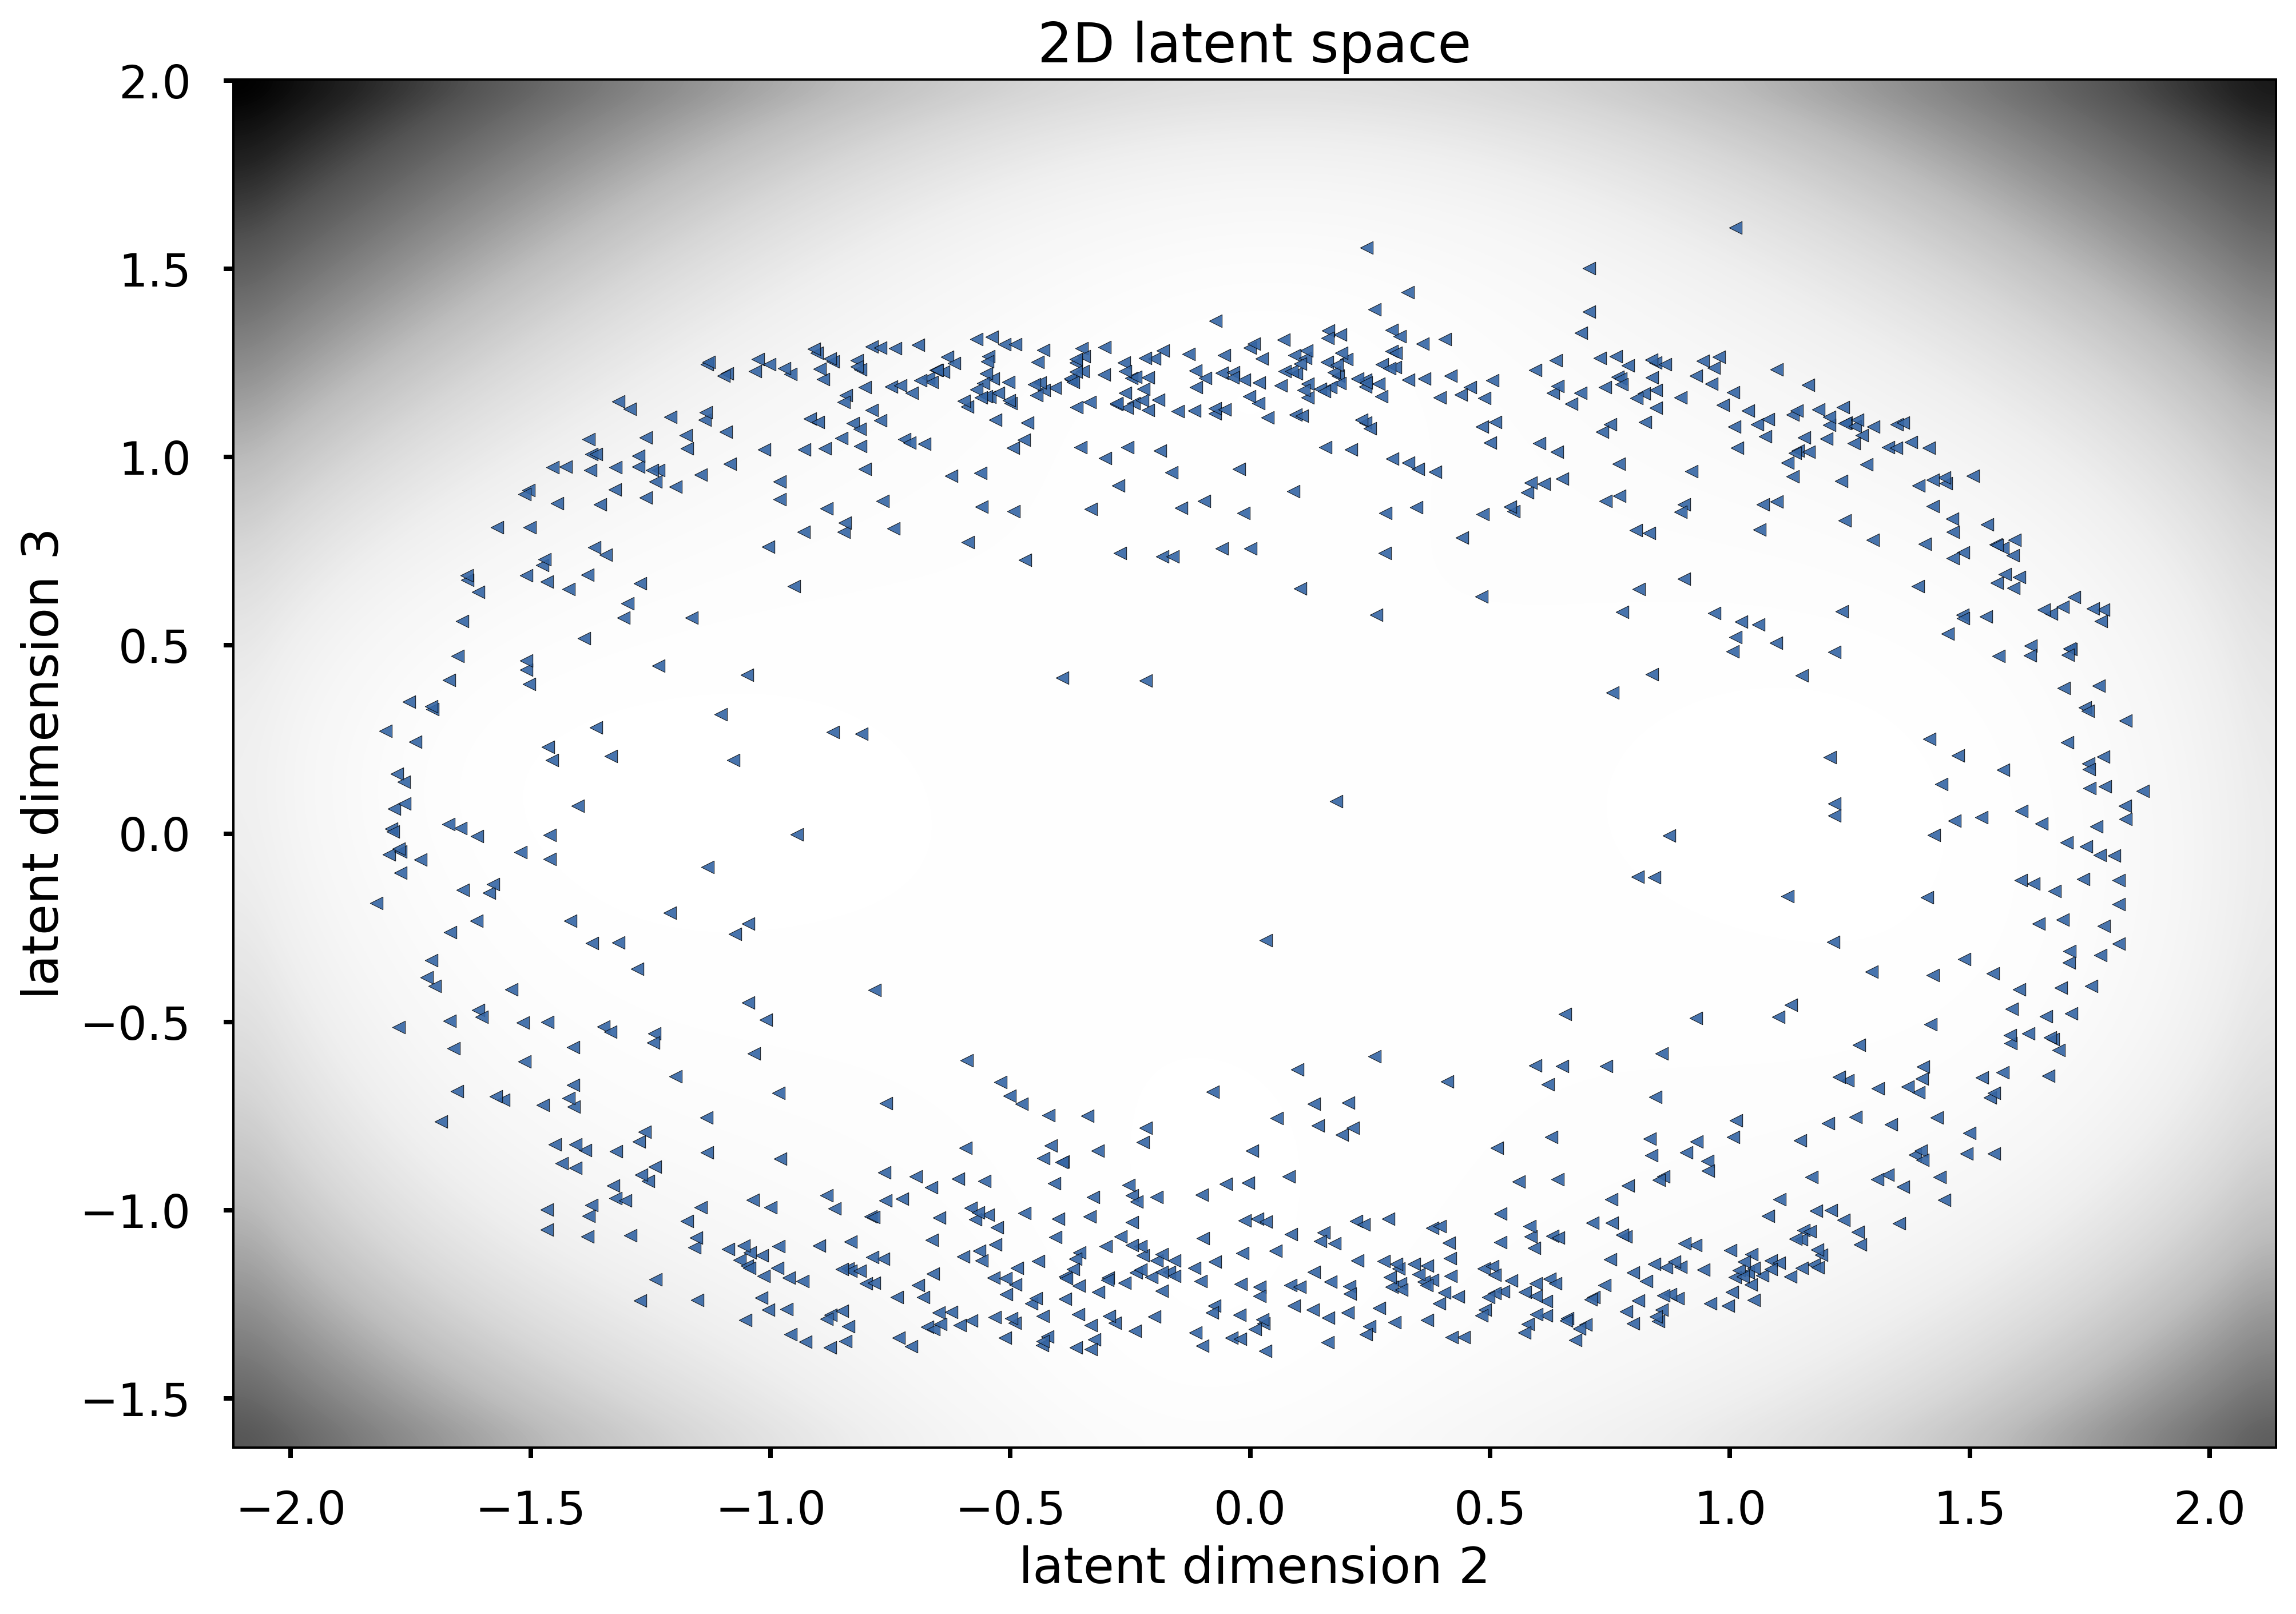

In [ ]:
# m_GPLVM.plot_latent(updates=False, legend =True, resolution=100)

fig, ax = plt.subplots()
ax.set_title('2D latent space')
labels = Y
m_GPLVM.plot_latent(ax=ax, updates=False, legend =True)
filename = shape_name_string + ' 2D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

In [ ]:
#use this to create an interactive 3D plot, use mouse buttons to translate, rotate and zoom
fig = go.Figure(data=[go.Scatter3d(x=latent[:, 2], y=latent[:,4], z=latent[:, 6],
                                   mode='markers',
                                   marker=dict(size=2, colorscale='Spectral',opacity=0.8)
                                   )])
fig.show()

In [ ]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(latent[:, input_dimension_1], latent[:,input_dimension_2], latent[:, input_dimension_3], c = latent[:, 2])
ax.set_title('3D latent space')

# Set axes label
ax.set_xlabel('input dimension ' + str(input_dimension_1), labelpad=20)
ax.set_ylabel('input dimension ' + str(input_dimension_2), labelpad=20)
ax.set_zlabel('input dimension ' + str(input_dimension_3), labelpad=20)

filename = shape_name_string + ' 3D latent.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)



Output hidden; open in https://colab.research.google.com to view.

In [ ]:
#Save/load the model

In [ ]:
# 1: Saving a model:
filename = shape_name_string + ' BGPLVM.npy'
np.save(filename, m_GPLVM.param_array)
files.download('/content/' + filename)
print(m_GPLVM)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


Name : bayesian gplvm
Objective : 10514.75247587054
Number of Parameters : 115047
Number of Optimization Parameters : 115047
Updates : True
Parameters:
  bayesian_gplvm.          |                 value  |  constraints  |  priors
  latent_space.mean        |             (8192, 7)  |               |        
  latent_space.variance    |             (8192, 7)  |      +ve      |        
  inducing_inputs          |               (50, 7)  |               |        
  rbf.variance             |  0.021473633163468165  |      +ve      |        
  rbf.lengthscale          |                  (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.003120824611785581  |      +ve      |        


In [ ]:
# 2: loading a model
# Model creation, without initialization:
m_load = GPy.models.BayesianGPLVM(Y, input_dim, kernel=k_GPLVM, init=init, num_inducing=num_inducing, initialize=False)
m_load.update_model(False) # do not call the underlying expensive algebra on load
m_load.initialize_parameter() # Initialize the parameters (connect the parameters up)
m_load[:] = np.load(filename) # Load the parameters
m_load.update_model(True) # Call the algebra only once
print(m_load)


Name : bayesian gplvm
Objective : 10514.75247587054
Number of Parameters : 115047
Number of Optimization Parameters : 115047
Updates : True
Parameters:
  bayesian_gplvm.          |                 value  |  constraints  |  priors
  latent_space.mean        |             (8192, 7)  |               |        
  latent_space.variance    |             (8192, 7)  |      +ve      |        
  inducing_inputs          |               (50, 7)  |               |        
  rbf.variance             |  0.021473633163468165  |      +ve      |        
  rbf.lengthscale          |                  (7,)  |      +ve      |        
  Gaussian_noise.variance  |  0.003120824611785581  |      +ve      |        


# Denoising

In [ ]:
#predict line elements for those points
predicted_line_elements, cov = m_GPLVM.predict(m_GPLVM.X)
print(predicted_line_elements.shape)
print(predicted_line_elements[0:5, :])

(8192, 7)
[[-0.73352733  0.67301563 -0.15102733  0.04559336  0.04788008  0.00690796
  -0.34896503]
 [ 0.44868883  0.4562842  -0.78381879 -0.53519813  0.23092307 -0.15677256
   0.71928448]
 [-0.86845792 -0.4100846   0.29297306  0.19857703 -0.34758634  0.12031244
  -0.29029728]
 [-0.75820551  0.5416539   0.31419596  0.29668974  0.23662398  0.29135276
   0.95957527]
 [-0.37512203 -0.35079502  0.83327098  0.0424962  -0.68217841 -0.28052762
   0.21516501]]


In [ ]:
points = np.zeros((Y.shape[0], 3))
for i in range(Y.shape[0]):
  p = np.cross(Y[i,0:3], Y[i,3:6]) + Y[i,6]*Y[i,0:3] #calculate the points from the line elements
  points[i,:] = p
print(points.shape)

pred_points = np.zeros((predicted_line_elements.shape[0], 3))
for i in range(predicted_line_elements.shape[0]):
  p = np.cross(predicted_line_elements[i,0:3], predicted_line_elements[i,3:6]) + predicted_line_elements[i,6]*Y[i,0:3] #calculate the points from the line elements
  pred_points[i,:] = p
print(pred_points.shape)


plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = 'b')
ax.scatter3D(pred_points[:, 0], pred_points[:,1], pred_points[:, 2], c = 'r')
ax.set_title('Reconstructed surface')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' reconstructed surface.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = 'b')
#ax.scatter3D(pred_points[:, 0], pred_points[:,1], pred_points[:, 2], c = 'r')
#ax.set_title('Noisy surface')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' noisy surface.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
plt.style.use('seaborn-poster')
ax = plt.axes(projection='3d')

#ax.scatter3D(points[:, 0], points[:,1], points[:, 2], c = 'b')
ax.scatter3D(pred_points[:, 0], pred_points[:,1], pred_points[:, 2], c = 'r')
#ax.set_title('Noisy surface')

# Set axes label
ax.set_xlabel('x', labelpad=20)
ax.set_ylabel('y', labelpad=20)
ax.set_zlabel('z', labelpad=20)

filename = shape_name_string + ' denoised surface.png'
plt.savefig(filename)
files.download('/content/' + filename)

plt.show(ax)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
points_combined = np.concatenate((points, pred_points), axis = 0)
labels_X = np.ones((points.shape[0], 1))*0
labels_pred = np.ones((pred_points.shape[0], 1))*1
labels_combined = np.concatenate((labels_X, labels_pred), axis = 0)
print(labels_combined.shape)
#print(labels_combined)

(16384, 1)


In [ ]:
fig = go.Figure(data=[go.Scatter3d(x=points_combined[:, 0], y=points_combined[:, 1], z=points_combined[:, 2],
                                   mode='markers',
                                   marker=dict(size=2, color = labels_combined[:, 0], colorscale='Bluered',opacity=0.5)
                                   )])
fig.update_layout(
    autosize=False,
    width=1000,
    height=1000,
    margin=dict(
        l=10,
        r=10,
        b=10,
        t=10,
        pad=4
    ),
)
fig.show( )

In [ ]:
filename = shape_name_string + ' predicted points.csv'
np.savetxt(filename, pred_points, delimiter=",")
files.download('/content/' + filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>